In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
import os, sys
from scipy.io import arff
from scipy import signal, interpolate
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import pdb
import time

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dirpath = os.path.join(os.getcwd(), 'dataset')

Using TensorFlow backend.


InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8504868864

In [21]:
# Read data

input_data = None

video_names = [
    '01_art_gallery_static.arff',
    '02_theatre_scene_static.arff',
    '03_lions_static_cuts.arff',
    '04_copenhagen_harbour_static_cuts.arff',
    '05_florida_yacht_motion.arff',
    '06_dance_experience_static.arff',
    '07_factory_robots_static.arff',
    '08_madagascar_cuts.arff',
    '09_elephants_static.arff',
    '10_cruise_festival_skate_cuts.arff',
    '11_lohdi_garden_india_cuts.arff',
    '12_gym_workout_static.arff',
    '13_times_square_static.arff',
    '14_new_orleans_drive_motion.arff',
    '15_interrogation_static.arff',
    '16_interview_static.arff',
    '17_weather_forecast_static.arff',
    '18_bomb_trapped_static.arff',
    '19_nurse_motion.arff',
    '20_car_fix_static.arff',
    '21_operation_room_static.arff',
    '22_surgical_checklist_static.arff',
    '23_dog_food_factory_motion.arff',
    '24_nurse_motion_challenge.arff',
    '25_theatre_scene_static_challenge.arff',
    '26_new_orleans_drive_motion_challenge.arff',
    '27_times_square_static_challenge.arff',
    '28_dance_experience_static_challenge.arff'
]

delta_t = 10000 # 10 milliseconds
columns = ['x', 'y', 'x_head', 'y_head', 'angle_deg_head', 'quaternion_hp_w',
        'quaternion_hp_x', 'quaternion_hp_y', 'quaternion_hp_z']
column_to_index = {}

for i, column in enumerate(columns):
    column_to_index[i] = column

for i in range(9,13):
    subjectId = str(i).zfill(3)
    for video_name in video_names:
        filename = subjectId + '_' + video_name
        # print(filename)
        fname = os.path.join(dirpath, subjectId, filename)
        # Load arff to structured array + metadata
        data, meta = arff.loadarff(fname)
        
        final_index = len(data) - 1
        while True:
            if data[final_index]['confidence'] == 0:
                final_index -= 1
            else:
                break

        initial_index = 0
        if data[initial_index]['confidence'] == 0:
            print('Warning: File ' + filename + ' starts with closed eyes, it will not be imported.')
            continue
        
        t_new = np.arange(data['time'][0], data['time'][final_index], delta_t)
        
        input_data_video = np.zeros((len(t_new), len(columns)))
        for j, column in enumerate(columns):
            if column in ['x', 'y']:
                index_confidence_0 = (data['confidence'] == 0)
                data_filtered = data[np.logical_not(index_confidence_0)]
            else:
                data_filtered = data
            
            f = interpolate.interp1d(data_filtered['time'], data_filtered[column])
            input_data_video[:, j] = f(t_new)
            
        if input_data is None:
            input_data = input_data_video
        else:
            input_data = np.concatenate([input_data, input_data_video])



# Normalize input_data
# mean = np.mean(input_data[index_training, :])
# std = np.std(input_data[index_training, :])


print("input_data shape: ", input_data.shape)
print("columns: ", columns)
input_data[:5, :]

input_data shape:  (629266, 9)
columns:  ['x', 'y', 'x_head', 'y_head', 'angle_deg_head', 'quaternion_hp_w', 'quaternion_hp_x', 'quaternion_hp_y', 'quaternion_hp_z']


array([[ 1.92000000e+03,  1.08000000e+03,  1.92334000e+03,
         1.10256000e+03, -7.17000000e+00, -9.90000000e-01,
        -1.00000000e-02, -8.00000000e-02,  6.00000000e-02],
       [ 1.92004778e+03,  1.08002444e+03,  1.92338556e+03,
         1.10260556e+03, -7.17444444e+00, -9.90000000e-01,
        -1.00000000e-02, -8.00000000e-02,  6.00000000e-02],
       [ 1.92022000e+03,  1.08002545e+03,  1.92347545e+03,
         1.10269545e+03, -7.18000000e+00, -9.90000000e-01,
        -1.00000000e-02, -8.00000000e-02,  6.00000000e-02],
       [ 1.92040800e+03,  1.08002000e+03,  1.92358600e+03,
         1.10279800e+03, -7.18000000e+00, -9.90000000e-01,
        -1.00000000e-02, -8.00000000e-02,  6.00000000e-02],
       [ 1.92044600e+03,  1.08008300e+03,  1.92370800e+03,
         1.10287300e+03, -7.18000000e+00, -9.90000000e-01,
        -1.00000000e-02, -8.00000000e-02,  6.00000000e-02]])

/home/demo/Documents/saliency-exploitation/sw/dataset/010/010_04_copenhagen_harbour_static_cuts.arff
example_np_data_raw shape:  (6103,)
(6145, 2)
(4944,)
1920.0
1920.0


Text(0, 0.5, 'y in equirectangular (raw)')

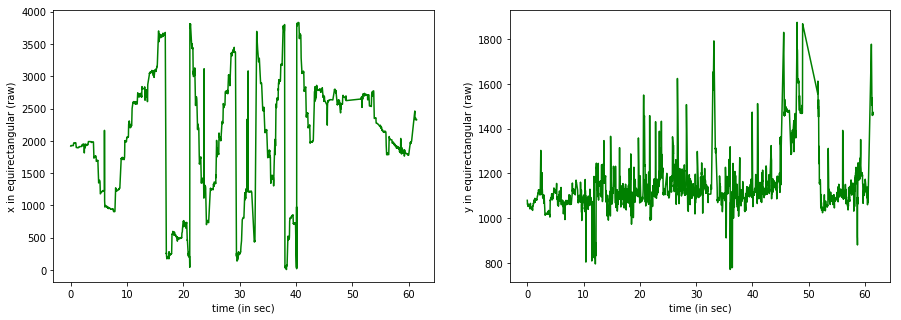

In [4]:
# Plot in seconds

fname = os.path.join(dirpath, '010', '010_04_copenhagen_harbour_static_cuts.arff')
print(fname)
# Load arff to pandas dataframe

example_data, example_meta = arff.loadarff(fname)
example_np_data_raw = data
print("example_np_data_raw shape: ", example_np_data_raw.shape)

example_np_data_raw[:3]

time_s_raw = example_np_data_raw['time'] / 1000000

delta_t = 10000 # 10 milliseconds

t_new = np.arange(example_np_data_raw['time'][0], example_np_data_raw['time'][-1], delta_t)

tmp_head = np.zeros((len(t_new),2))
for j, column in enumerate(['x_head', 'y_head']):
    f = interpolate.interp1d(example_np_data_raw['time'], example_np_data_raw[column])
    tmp_head[:,j] = f(t_new)
x_y_head_data = tmp_head

print(x_y_head_data.shape)

tmp = np.zeros((len(t_new), 2))
index_confidence_0 = (example_np_data_raw['confidence'] == 0)
np_data_filtered = example_np_data_raw[np.logical_not(index_confidence_0)]
print(np_data_filtered.shape)
for j, column in enumerate(['x', 'y']):
    f = interpolate.interp1d(np_data_filtered['time'], np_data_filtered[column])
    tmp[:, j] = f(t_new)
x_y_data = tmp
print(x_y_data[0, 0])
print(example_np_data_raw['x'][0])

t_new_s = t_new / 1000000

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(121)
x_data_raw = example_np_data_raw['x']
x_data = x_y_data[:, 0]

plt.plot(t_new_s, x_data, 'g')
# plt.plot(time_s_raw, x_data_raw, 'r')
plt.xlabel('time (in sec)')
plt.ylabel('x in equirectangular (raw)')

plt.subplot(122)
y_data_raw = example_np_data_raw['y']
y_data = x_y_data[:, 1]
plt.plot(t_new_s, y_data, 'g')
# plt.plot(time_s_raw, y_data_raw, 'r')
plt.xlabel('time (in sec)')
plt.ylabel('y in equirectangular (raw)')


Text(0, 0.5, 'y in equirectangular (smooth)')

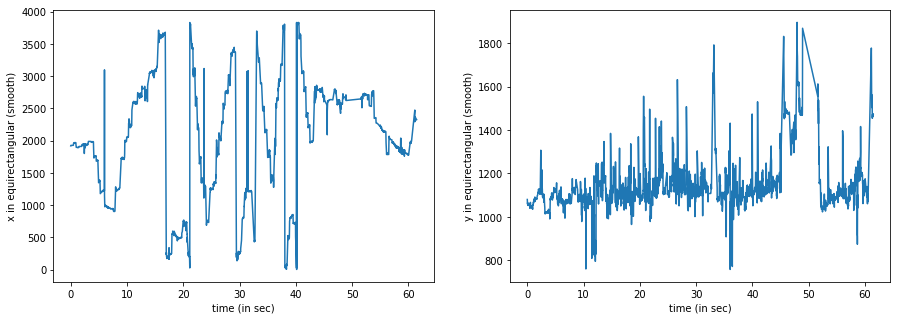

In [5]:
# get indexes where confidence == 0
index_confidence_0 = (example_np_data_raw['confidence'] == 0)

example_np_data = np.copy(example_np_data_raw)
time_s = np.copy(time_s_raw)

'''
x_smooth = signal.savgol_filter(np_data_raw['x'], 201, 1)
y_smooth = signal.savgol_filter(np_data_raw['y'], 201, 1)

np_data['x'] = x_smooth
np_data['y'] = y_smooth
'''

# TODO: INTERPOLATE x and y where gaze confidence == 0

# Filter lines where gaze confidence == 0 (to be changed)
example_np_data = example_np_data[np.logical_not(index_confidence_0)]
time_s = time_s[np.logical_not(index_confidence_0)]

# np_data['x'][index_confidence_0] = x_smooth[index_confidence_0]
# np_data['y'][index_confidence_0] = y_smooth[index_confidence_0]

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(121)
x_data = example_np_data['x']
plt.plot(time_s, x_data)
plt.xlabel('time (in sec)')
plt.ylabel('x in equirectangular (smooth)')

plt.subplot(122)
y_data = example_np_data['y']
plt.plot(time_s, y_data)
plt.xlabel('time (in sec)')
plt.ylabel('y in equirectangular (smooth)')

Text(0, 0.5, 'y_head in equirectangular')

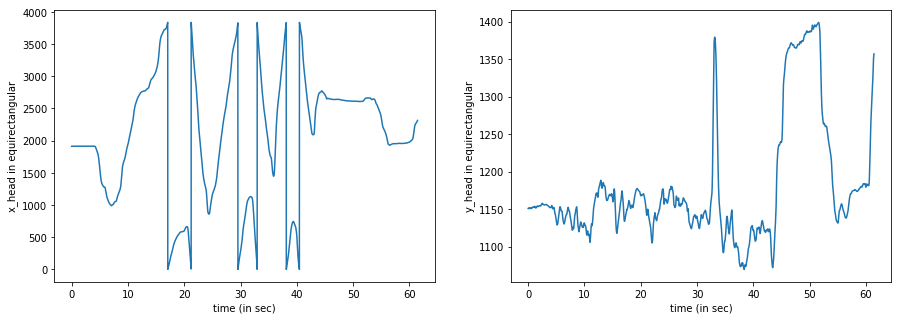

In [6]:
# Plot in seconds

plt.subplots(1, 2, figsize=(15,5))

plt.subplot(121)
xhead_data = example_np_data_raw['x_head']
plt.plot(time_s_raw, xhead_data)
plt.xlabel('time (in sec)')
plt.ylabel('x_head in equirectangular')

plt.subplot(122)
yhead_data = example_np_data_raw['y_head']
plt.plot(time_s_raw, yhead_data)
plt.xlabel('time (in sec)')
plt.ylabel('y_head in equirectangular')

Text(0, 0.5, 'z_quaternion')

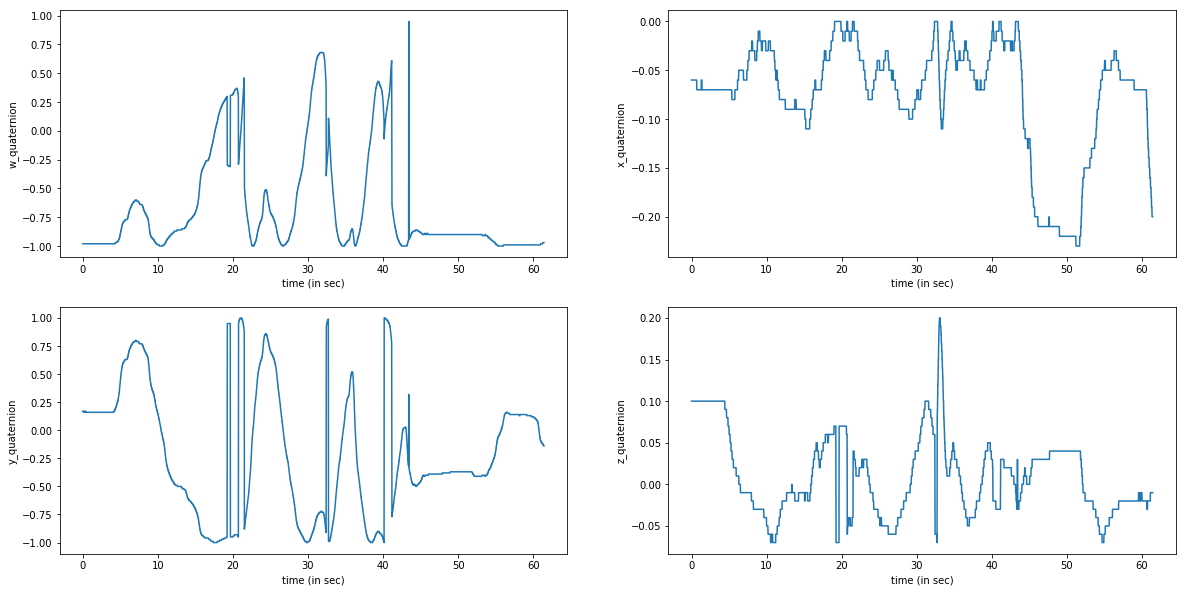

In [7]:
# Inspect data (more plots)

plt.subplots(2, 2, figsize=(20,10))

plt.subplot(221)
w = example_np_data_raw['quaternion_hp_w'] # w_quaternion
plt.plot(time_s_raw, w)
plt.xlabel('time (in sec)')
plt.ylabel('w_quaternion')


plt.subplot(222)
x = example_np_data_raw['quaternion_hp_x'] # x_quaternion
plt.plot(time_s_raw, x)
plt.xlabel('time (in sec)')
plt.ylabel('x_quaternion')

plt.subplot(223)
y = example_np_data_raw['quaternion_hp_y'] # y_quaternion
plt.plot(time_s_raw, y)
plt.xlabel('time (in sec)')
plt.ylabel('y_quaternion')

plt.subplot(224)
z = example_np_data_raw['quaternion_hp_z'] # z_quaternion
plt.plot(time_s_raw, z)
plt.xlabel('time (in sec)')
plt.ylabel('z_quaternion')


In [8]:
# Normalize the data
# Subtract mean and divide by standard deviation
total_length = example_np_data_raw.size
print('example_np_data_raw.shape', example_np_data_raw.shape)

percentage_training = 0.7
percentage_val = 0.1
percentage_test = 0.2

training_size = int(np.floor(total_length * percentage_training))
index_training = range(training_size)
val_size = int(np.floor(total_length * (percentage_training + percentage_val)))
index_val = range(training_size + 1, val_size)
index_test = range(val_size + 1, total_length)

x_head_raw = example_np_data_raw['x_head']
y_head_raw = example_np_data_raw['y_head']

input_x_y = np.column_stack((x_head_raw, y_head_raw))

mean = np.mean(input_x_y[index_training, :])
std = np.std(input_x_y[index_training, :])

input_x_y_normalized = (input_x_y - mean) / std

# mean_y = np.mean(y_head_raw[index_training])
# std_y = np.std(y_head_raw[index_training])

# y_normalized = (y_head_raw - mean_y) / std_y

input_x_y_normalized

example_np_data_raw.shape (6103,)


array([[ 0.2504755 , -1.06953376],
       [ 0.25042357, -1.069603  ],
       [ 0.25033701, -1.06967225],
       ...,
       [ 0.93967575, -0.71293685],
       [ 0.94232439, -0.71259062],
       [ 0.94499034, -0.71226171]])

In [9]:
# Define data generator (yield)
def generator(data, lookback, delay, min_index, max_index,
    shuffle=False, batch_size=128, step=4):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
            lookback // step,
            data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            '''
            print('samples', samples.shape)
            print('data[indices]', data[indices].shape)
            print('data', data.shape)
            print('indices', indices)
            print('targets', targets.shape)
            print(data[indices])
            
            '''
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
# Formulation of the problem: Given sensor data going as far back as
# 'lookback' timesteps and sampled every 'steps' timesteps,
# predict the x and y in 'delay' timesteps?

lookback = 120 # ~1 second in the past
step = 4 # ~ 1 per frame
delay = 120 # ~ 1 second in the future

batch_size = 128

train_gen_x_y = generator(input_x_y_normalized,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=training_size,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_x_y = generator(input_x_y_normalized,
    lookback=lookback,
    delay=delay,
    min_index=training_size+1,
    max_index=val_size,
    step=step,
    batch_size=batch_size)
test_gen_x_y = generator(input_x_y_normalized,
    lookback=lookback,
    delay=delay,
    min_index=val_size+1,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (val_size - (training_size + 1) - lookback)
test_steps = (total_length - (val_size + 1) - lookback)

In [11]:
# Create baseline model (no machine learning)
# - Field of view center will move in the same direction and velocity as in the last 0.5s (15 frames)

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen_x_y)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mae = evaluate_naive_method()

print(mae)

0.035052683662717465


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1952      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
500/500 [==============================] - 2s 4ms/step - loss: 0.1415 - val_loss: 0.0600
Epoch 2/30
500/500 [==============================] - 2s 4ms/step - loss: 0.0809 - val_loss: 0.0420
Epoch 3/30
500/500 [==============================] - 2s 4ms/step - loss: 0.0696 - val_loss: 0.0616
Epoch 4/30
500/500 [==============================] - 2s 4ms/step - loss: 0.0

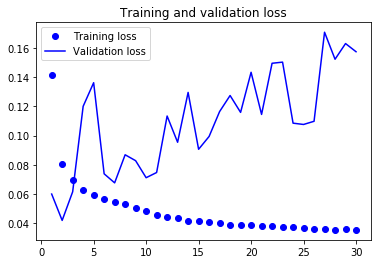

In [12]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, input_x_y_normalized.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
print(model.summary())
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_x_y,
    steps_per_epoch=500,
    epochs=30,
    validation_data=val_gen_x_y,
    validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

2
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, None, 32)          3456      
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 22,145
Trainable params: 22,145
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
500/500 [==============================] - 13s 26ms/step - loss: 0.0783 - val_loss: 0.1916
Epoch 2/10
500/500 [==============================] - 12s 25ms/step - loss: 0.0528 - val_loss: 0.2261
Epoch 3/10
500/500 [==============================] - 12s 25ms/step - loss: 0.0472 - val_loss: 0.2810
Epoch 4/10
500/500 [==============================] - 12s 25ms/step

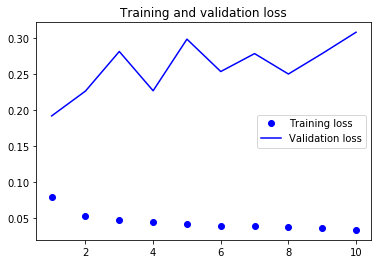

In [16]:
# Training and evaluating a dropout-regularized, stacked GRU model

print(input_x_y_normalized.shape[-1])
model = Sequential()
model.add(layers.CuDNNGRU(32,
    return_sequences=True,
    input_shape=(None, input_x_y_normalized.shape[-1])))
model.add(layers.GRU(64, activation='relu',
    dropout=0.1,
    recurrent_dropout=0.5))
model.add(layers.Dense(1))
print(model.summary())

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen_x_y,
    steps_per_epoch=500,
    epochs=10,
    validation_data=val_gen_x_y,
    validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()